# 1D Systematics treatment

## Imports

In [1]:
import torch 
import h5py
import os 
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

from torch.utils.data import TensorDataset, DataLoader

sys.path.insert(0, "/home/lai/nplm/src")
from plot_utils import set_label_font, set_tick_font, draw_grid
from analysis_utils import compute_df, produce_bins, save_binning, load_binning
from nn_utils import ParametricNet, delta_nu_poly, parametric_loss
from data_utils import read_data_with_nu, normalize_data

## Config

In [2]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [3]:
hep.style.use(hep.style.CMS)

## Constants

In [4]:
# Set random seed
SEED = 1231244
torch.manual_seed(SEED)
np.random.seed(SEED)

# Plotting parameters
FONTSIZE  = 24
FIGSIZE   = (10, 8)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

# Luminosity
NR0 = 20_000

PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
    
DATA_PATH = "./data/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [5]:
INPUT_SIZE  = 1 # x
INPUT_SHAPE = (INPUT_SIZE,)
LAYERS      = [INPUT_SIZE, 30, 30, 1]

# number of training epochs
EPOCHS         = 1000
# after how many epochs to gather the loss and accuracy
PATIENCE       = 100
# weight-clipping
WCLIP          = 7
# polynomial degree of the approximation
POLY_DEGREE    = 3
# activation function
ACTIVATION     = torch.nn.Sigmoid()
# batch fraction 
BATCH_FRACTION = 1 # 0.3
# gather after
GATHER_AFTER   = 1# int(1. / BATCH_FRACTION)
# learning rate
LEARNING_RATE  = 0.01

## DATASETS

In [6]:
bins       = load_binning(path=DATA_PATH, name="binning_1dexpon.h5")
bincenters = 0.5*(bins[1:]+bins[:-1])
binwidths  = bins[1:]-bins[:-1]

In [7]:
feature     = np.array([])
targets     = np.array([])
weights     = np.array([])
nuisance    = np.array([])
nu_list     = np.array([-2, -1, -0.5, 0.5, 1, 2])
# nu_list     = np.array([ -0.2, -0.1, -0.05, 0.05, 0.1, 0.2])
nu_std      = np.std(nu_list)
nu_list_std = nu_list*1./nu_std

In [8]:
# create strings for saving files
architecture = ''
for l in LAYERS:
    architecture += str(l)+'_'
    
nu_string = ''
for nu in nu_list:
    nu_string += str(nu)+'_'

### Central value

In [9]:
ref      = read_data_with_nu(data_path=DATA_PATH, nu=0)
w_ref    = np.ones_like(ref)
n_ref    = ref.shape[0]
idx_ref  = np.arange(n_ref)

mean_ref = np.mean(ref).reshape(1, -1)
std_ref  = np.std(ref).reshape(1, -1)

### Nuisance variations

In [10]:
# for each value of the nuisance parameter:
for nu in nu_list:
    
    # find the index of the nuisance parameter in the list
    i = np.where(nu==nu_list)[0][0]
        
    # get the corresponding standard deviation of the nuisance parameter     
    nu_std = nu_list_std[i]
    
    data = read_data_with_nu(data_path=DATA_PATH, nu=nu)
    w_data = np.ones_like(data)
            
    n_data   = data.shape[0]
    idx_data = np.arange(n_data)
    
    # shuffle the data and reference samples
    np.random.shuffle(idx_ref)
    np.random.shuffle(idx_data)
    
    # create a mask for the data and reference samples with the correct luminosity scaling
    mask_REF   = (idx_ref  < NR0)
    mask_DATA  = (idx_data < NR0)
    
    # features_nu is the concatenation of the reference and data samples along the 0th axis for one value of the nuisance parameter
    feature_nu = np.concatenate((ref[mask_REF], data[mask_DATA]), axis=0)
    
    # targets_nu is the concatenation of the reference and data targets along the 0th axis for one value of the nuisance parameter
    # zeros for the reference, central value, and ones for the data, shifted value of the nuisance parameter
    targets_nu = np.append(np.zeros(ref[mask_REF].shape[0]), np.ones(data[mask_DATA].shape[0]))
    
    # nuisance_nu is the nuisance parameter std replicated for the total number of samples (reference + data)
    nuisanc_nu = np.ones(feature_nu.shape[0])*nu_std
    
    # weights_nu is the concatenation of the reference and data weights along the 0th axis for one value of the nuisance parameter
    weights_nu = np.append(w_ref[mask_REF], w_data[mask_DATA])
    
    
    # if this is the first value of the nuisance parameter, set the feature, target, weight, year label, and nuisance parameter arrays to the values for this value of the nuisance parameter
    if feature.shape[0]==0:
        feature  = feature_nu
        targets  = targets_nu
        weights  = weights_nu
        nuisance = nuisanc_nu
        
    # otherwise, concatenate the feature, target, weight, year label, and nuisance parameter arrays with the values for this value of the nuisance parameter
    else:
        feature  = np.concatenate((feature,  feature_nu), axis=0)
        targets  = np.concatenate((targets,  targets_nu), axis=0)
        weights  = np.concatenate((weights,  weights_nu), axis=0)
        nuisance = np.concatenate((nuisance, nuisanc_nu), axis=0)

### Plot datasets

In [11]:
# histo_nu_list = []

# fig, ax = plt.subplots(figsize=FIGSIZE)
# draw_grid(ax)
# set_label_font(ax, FONTSIZE)
# set_tick_font(ax, FONTSIZE-2)

# x_ref = feature[(targets==0)][:, 0]
# w_ref = weights[(targets==0)] * 1./len(nu_list)

# hist_ref = ax.hist(x_ref, bins=bins, weights=w_ref, histtype="step", ls="--", lw=2, label="central value", color="black")[0]

# for nu_iter in range(len(nu_list)):
    
#     nu     = nu_list[nu_iter]
#     nu_std = nu_list_std[nu_iter]
    
#     x_nu = feature[(nuisance==nu_std) & (targets==1)][:, 0]
#     w_nu = weights[(nuisance==nu_std) & (targets==1)]
    
#     hist = ax.hist(
#         x_nu, 
#         bins=bins, 
#         weights=w_nu, 
#         histtype="step", 
#         lw=2, 
#         label=r"$\nu$ = %s"%(str(nu)), 
#         color=PALETTE_2[::-1][nu_iter]
#     )[0]

#     histo_nu_list.append(hist)
    
# ax.legend(fontsize=FONTSIZE-4, ncols=1, bbox_to_anchor=(1.0, 1.0), loc="upper left")

# # ax.set_xscale("log")
# ax.set_yscale("log")
# # ax.set_xlim(1e-2, 0.3e2)

# ax.set_xlabel("x")
# ax.set_ylabel("Events")

# plt.show()

In [12]:
# fig, ax = plt.subplots(figsize=FIGSIZE)
# set_label_font(ax, FONTSIZE)
# set_tick_font(ax, FONTSIZE-2)
# draw_grid(ax)

# ax.axhline(y=0, color="black", ls="--", lw=2, alpha=0.5)


# ratios = []
# log_ratios = []
# ratio_errs = []
# log_ratio_errs = []

# for nu_iter in range(len(nu_list)):
#     nu = nu_list[nu_iter]
#     nu_std = nu_list_std[nu_iter]
    
#     x_ref = feature[(nuisance==nu_std) & (targets==0)][:, 0]
#     w_ref = weights[(nuisance==nu_std) & (targets==0)]
    
#     x_nu  = feature[(nuisance==nu_std) & (targets==1)][:, 0]
#     w_nu  = weights[(nuisance==nu_std) & (targets==1)]

#     histo_ref = np.histogram(x_ref, bins=bins, weights=w_ref)[0]
#     histo_nu  = np.histogram(x_nu,  bins=bins, weights=w_nu)[0]
    
#     histo_ref_sq = np.histogram(x_ref, bins=bins, weights=w_ref**2)[0]
#     histo_nu_sq  = np.histogram(x_nu,  bins=bins, weights=w_nu**2)[0]
    
#     ratio = histo_nu*1./(histo_ref)
#     ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )
    
#     log_ratio = np.log(ratio)
#     log_ratio_err = ratio_err*1./ratio
    
#     ratios.append(ratio)
#     log_ratios.append(log_ratio)
#     ratio_errs.append(ratio_err)
#     log_ratio_errs.append(log_ratio_err)
    
#     ax.errorbar(
#         x          = bincenters, 
#         y          = log_ratio, 
#         yerr       = log_ratio_err, 
#         xerr       = binwidths/2,
#         marker     = 'o',
#         ls         = '',
#         lw         = 2,
#         label      = r'$\nu$ = %s'%(str(nu)), 
#         color      = PALETTE_2[::-1][nu_iter], 
#         markersize = 10,
#         elinewidth = 2,
#         capsize    = 5,
#         capthick   = 2
#     )
    
# ax.set_xlabel("x")
# ax.set_ylabel(r'$log[n({x}|\,\nu)\,/ \, n({x}|\,0)]$')

# ax.set_xscale("log")
# ax.set_xlim(1e-2, 0.3e2)

# ax.legend(fontsize=FONTSIZE-4, ncols=1, bbox_to_anchor=(1.0, 1.0), loc="upper left")

    
# plt.show()

### Standardization

In [13]:
feature = normalize_data(feature, mean_ref, std_ref)

# Convert to PyTorch tensors after all preprocessing is done
feature  = torch.tensor(feature,  dtype=torch.float32)
targets  = torch.tensor(targets,  dtype=torch.float32)
weights  = torch.tensor(weights,  dtype=torch.float32)
nuisance = torch.tensor(nuisance, dtype=torch.float32)

# Stack the target array
target   = torch.stack([targets, weights, nuisance], dim=1)

## PARAMETRIC NETWORK

In [14]:
# split training, validation and test
fraction_validation = 0.2
fraction_test       = 0.2
fraction_training   = 1 - fraction_validation - fraction_test

# shuffle the data
n_data = feature.shape[0]
idx    = np.arange(n_data)
np.random.shuffle(idx)

# masks for splitting the data
mask_val   = (idx <  int(n_data*fraction_validation))
mask_test  = (idx >= int(n_data*fraction_validation)) * (idx < int(n_data*(fraction_validation+fraction_test)))
mask_train = (idx >= int(n_data*(fraction_validation+fraction_test)))

# split the data
feature_test,  target_test  = feature[mask_test],  target[mask_test]
feature_train, target_train = feature[mask_train], target[mask_train]
feature_val,   target_val   = feature[mask_val],   target[mask_val]

In [15]:
# create the model
model = ParametricNet(
    architecture      = LAYERS, 
    activation        = ACTIVATION, 
    poly_degree       = POLY_DEGREE, 
    initial_model     = None,
    train_coeffs      = True,
    device            = device
).to(device)
# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# clip the initial weights of the model 
model.clip_weights(0.1)

In [16]:
# Train the model
model.train_model(
    feature_train,
    target_train,
    feature_val,
    target_val,
    EPOCHS, 
    optimizer, 
    WCLIP, 
    PATIENCE,
    GATHER_AFTER,
    BATCH_FRACTION,
)

epoch: 100, loss: 24.846778717041015, val_loss: 24.61952781677246
epoch: 200, loss: 24.61041883468628, val_loss: 24.61048126220703
epoch: 300, loss: 24.60507698059082, val_loss: 24.607934951782227
epoch: 400, loss: 24.603057918548583, val_loss: 24.607372283935547
epoch: 500, loss: 24.602229480743407, val_loss: 24.607275009155273
epoch: 600, loss: 24.601857433319093, val_loss: 24.60722541809082
epoch: 700, loss: 24.601656341552733, val_loss: 24.607149124145508
epoch: 800, loss: 24.601524848937988, val_loss: 24.607057571411133
epoch: 900, loss: 24.601427268981933, val_loss: 24.606969833374023
epoch: 1000, loss: 24.608841724395752, val_loss: 24.609827041625977


/tmp/ipykernel_1113033/2081003454.py:26: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )
/tmp/ipykernel_1113033/2081003454.py:28: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(ratio)


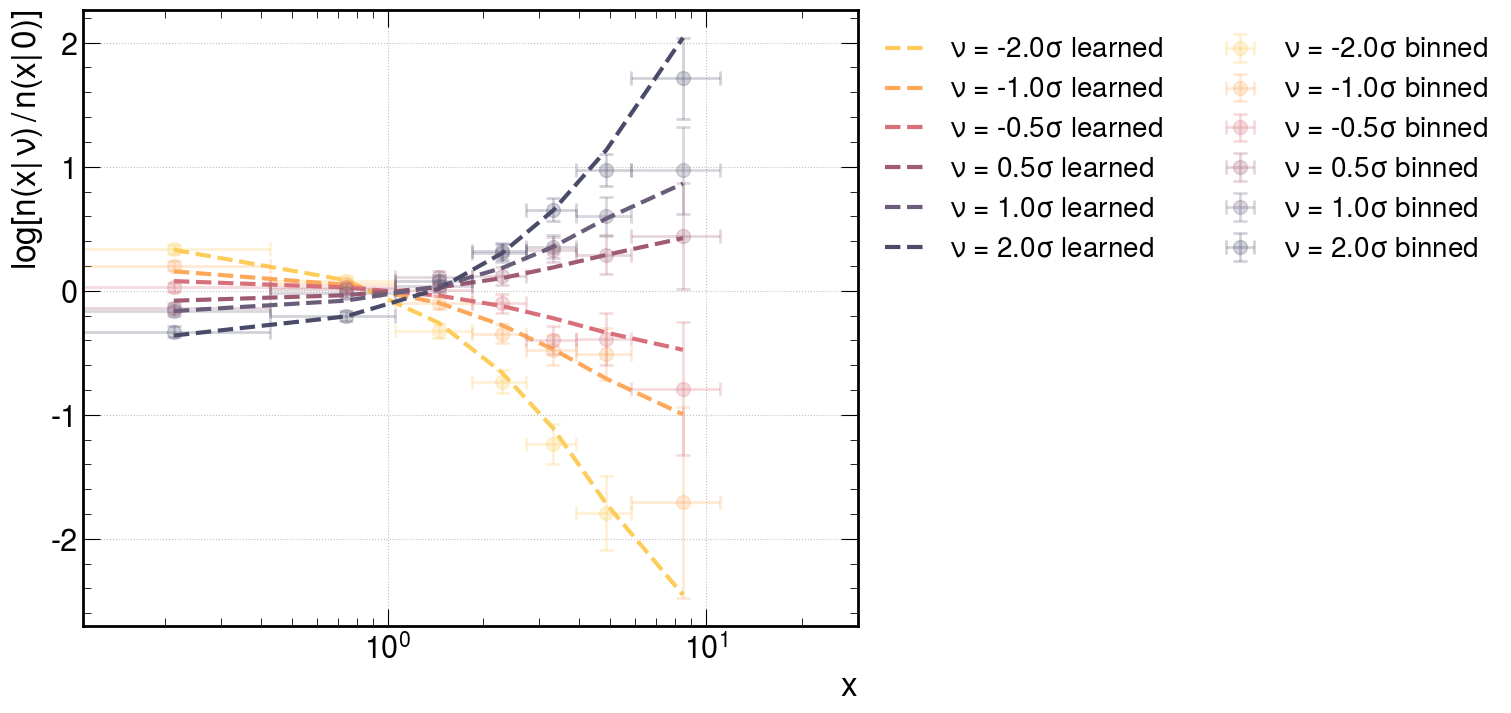

In [18]:
# create figure and axes
fig, ax = plt.subplots(figsize=FIGSIZE)
draw_grid(ax)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)


# for each nuisance parameter
for nu_iter in range(len(nu_list)):
    nu = nu_list[nu_iter]
    nu_std = nu_list_std[nu_iter]
    
    x_ref = feature_test[(target_test[:,2]==nu_std)     & (target_test[:,0]==0)][:, 0]
    w_ref = target_test[:,1][(target_test[:,2]==nu_std) & (target_test[:,0]==0)]
    
    x_nu  = feature_test[(target_test[:,2]==nu_std)     & (target_test[:,0]==1)][:, 0]
    w_nu  = target_test[:,1][(target_test[:,2]==nu_std) & (target_test[:,0]==1)]

    histo_ref = np.histogram(x_ref, bins=bins, weights=w_ref)[0]
    histo_nu  = np.histogram(x_nu,  bins=bins, weights=w_nu)[0]
    
    histo_ref_sq = np.histogram(x_ref, bins=bins, weights=w_ref**2)[0]
    histo_nu_sq  = np.histogram(x_nu,  bins=bins, weights=w_nu**2)[0]
    
    ratio = histo_nu*1./(histo_ref)
    ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )
    
    log_ratio = np.log(ratio)
    log_ratio_err = ratio_err*1./ratio
        
    # plot the already-computed binned log-ratio
    ax.errorbar(
        x          = bincenters, 
        y          = log_ratio,
        yerr       = log_ratio_err,
        xerr       = binwidths / 2,
        marker     = 'o',
        ls         = '',
        lw         = 0,
        label      = r'$\nu$ = %s$\sigma$ binned'%(str(nu)), 
        color      = PALETTE_2[::-1][nu_iter], 
        markersize = 10,
        elinewidth = 2,
        capsize    = 5,
        capthick   = 2,
        alpha      = 0.25
    )
    
    # masks to retreive the validation data corresponding to this nuisance parameter
    maskR = (target_test[:, -1]==nu_std) * (target_test[:, 0]==0)
    maskD = (target_test[:, -1]==nu_std) * (target_test[:, 0]==1)
    
    # retrieve the validation data
    featR = feature_test[maskR]
    featD = feature_test[maskD]
    
    pred_test = model(feature_test.to(device))
    poly_test = delta_nu_poly(target_test.to(device), pred_test)
    deltR = np.exp(poly_test[maskR].cpu().detach().numpy())
    
    # retreive the weights
    weig = target_test[:, 1]
    weigR = weig[maskR]
    weigD = weig[maskD]
    

    hist_sumD = np.histogram(featD[:, 0]*mean_ref[0], weights=weigD,       bins=bins)[0]
    
    # reweight the reference data
    hist_sumW = np.histogram(featR[:, 0]*mean_ref[0], weights=weigR*deltR, bins=bins)[0]
    
    hist_sum  = np.histogram(featR[:, 0]*mean_ref[0], weights=weigR,       bins=bins)[0]
    
    ax.plot(bincenters, np.log(hist_sumW/hist_sum), color=PALETTE_2[::-1][nu_iter], lw=3, ls='--', label = r'$\nu$ = %s$\sigma$ learned'%(str(nu)))


ax.set_xlabel("x")
ax.set_ylabel(r'$log[n({x}|\,\nu)\,/ \, n({x}|\,0)]$')

ax.set_xscale("log")
ax.set_xlim(1.1e-1, 0.3e2)
# ax.set_ylim(-4, 4)

ax.legend(fontsize=FONTSIZE-4, ncols=2, bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.show()